<a href="https://colab.research.google.com/github/Artenida/computer_vision_lessons/blob/main/Supervised_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


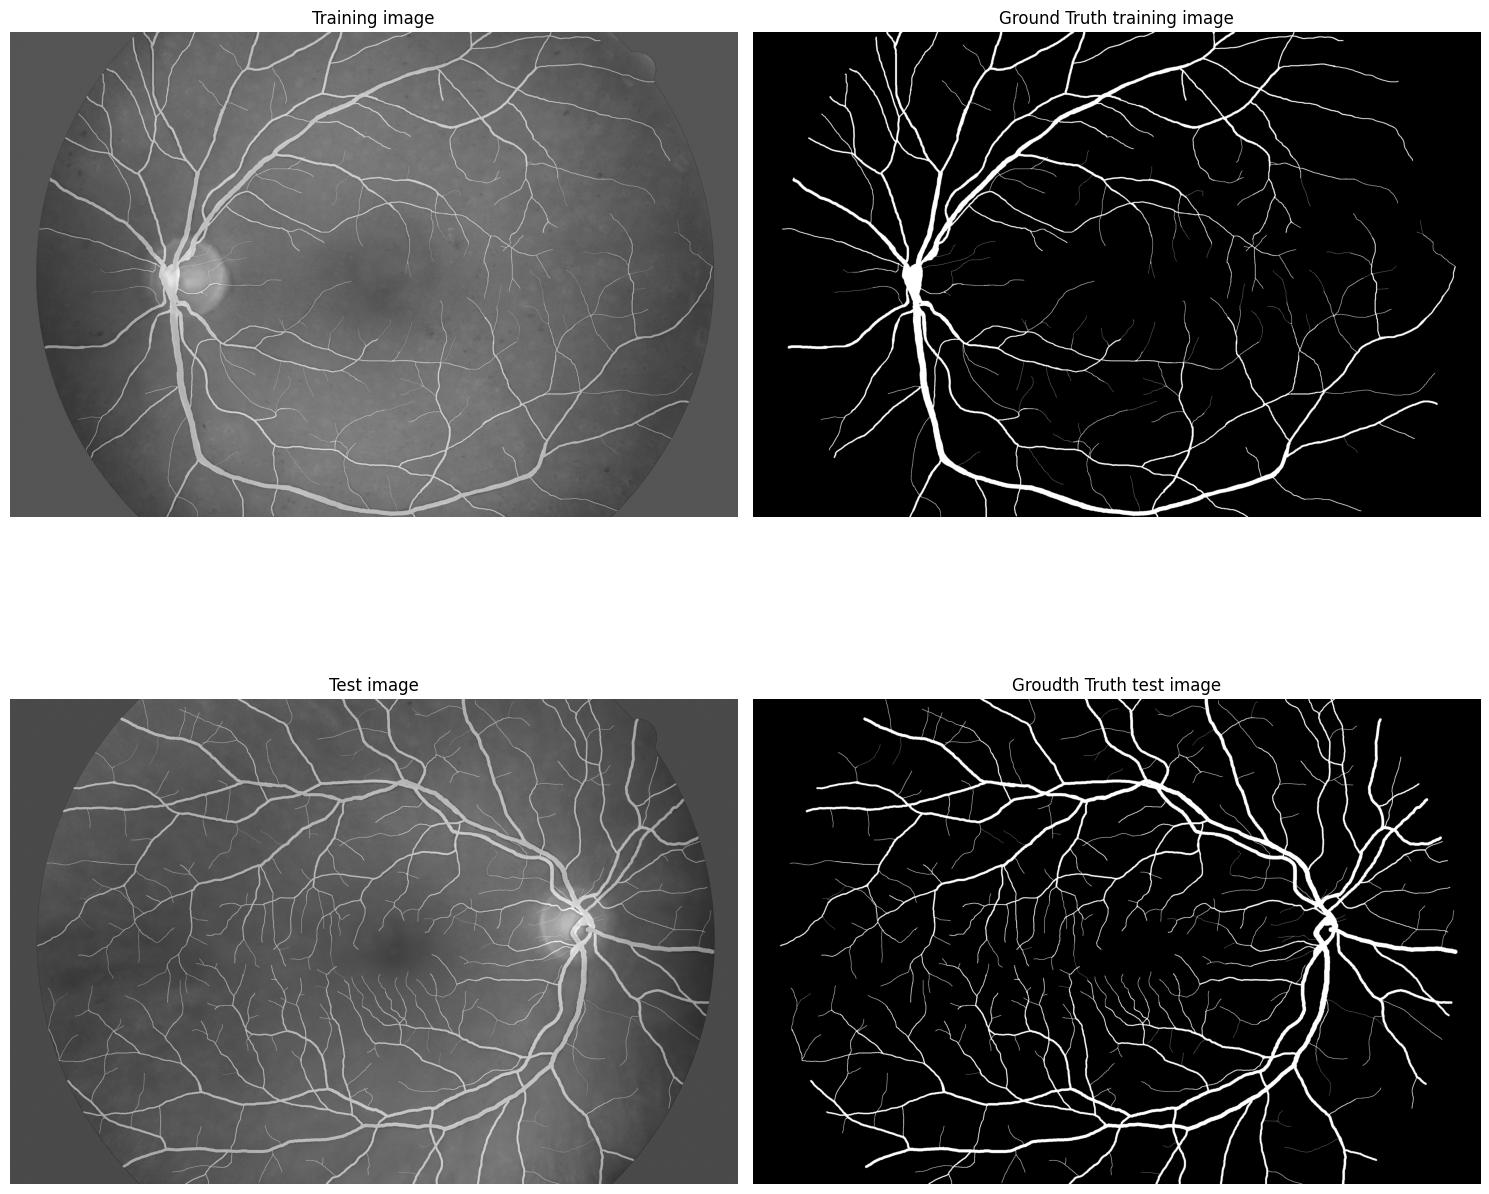

In [2]:
import skimage as sk
import matplotlib.pyplot as plt
from skimage import io
import os
from matplotlib import gridspec

# Path of the folder in your google drive unit where you have the images:

path = '/content/drive/MyDrive/Colab Notebooks/Images'

I_train = sk.io.imread(os.path.join(path,'vessels_train.jpg'))
I_train_GT = sk.io.imread(os.path.join(path,'vessels_train_GT.tif'))
I_test = sk.io.imread(os.path.join(path,'vessels_test.jpg'))
I_test_GT = sk.io.imread(os.path.join(path,'vessels_test_GT.tif'))

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_train, cmap=plt.cm.gray)
ax0.set_title('Training image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_train_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth training image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_test, cmap=plt.cm.gray)
ax2.set_title('Test image')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_test_GT, cmap=plt.cm.gray)
ax3.set_title('Groudth Truth test image')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

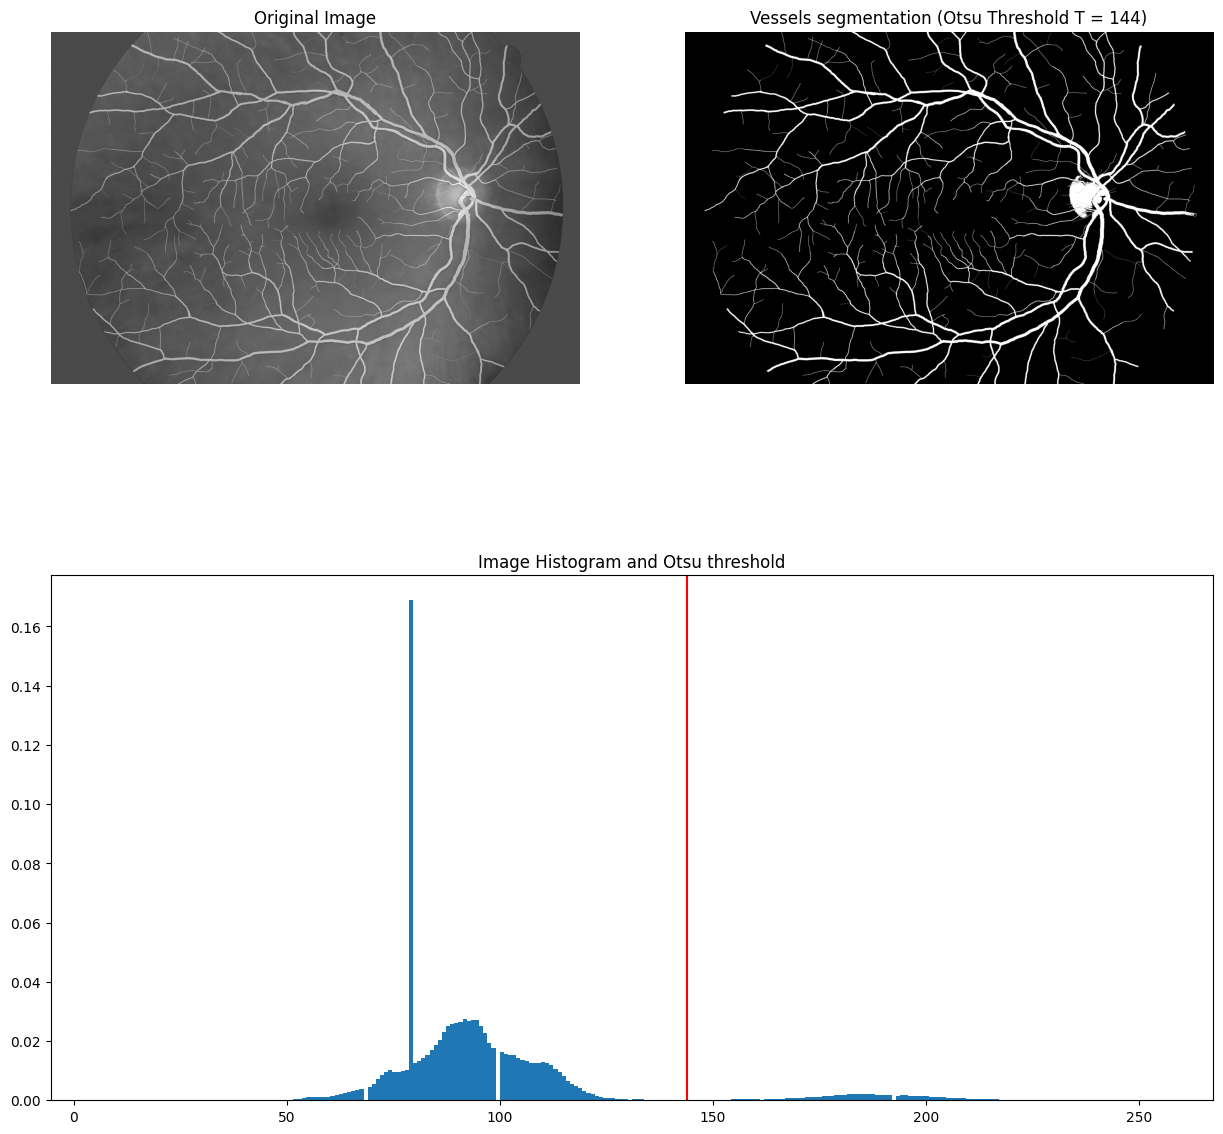

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu

# Find Otsu's threshold for training image:
threshold_otsu = threshold_otsu(I_train)

# Apply threshold to test image:
I_otsu = I_test >= threshold_otsu

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Otsu Threshold T = {})'.format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(I_test.ravel(), bins=256,density=True)
ax3.axvline(threshold_otsu, color='r')
ax3.set_title('Image Histogram and Otsu threshold')
plt.show()

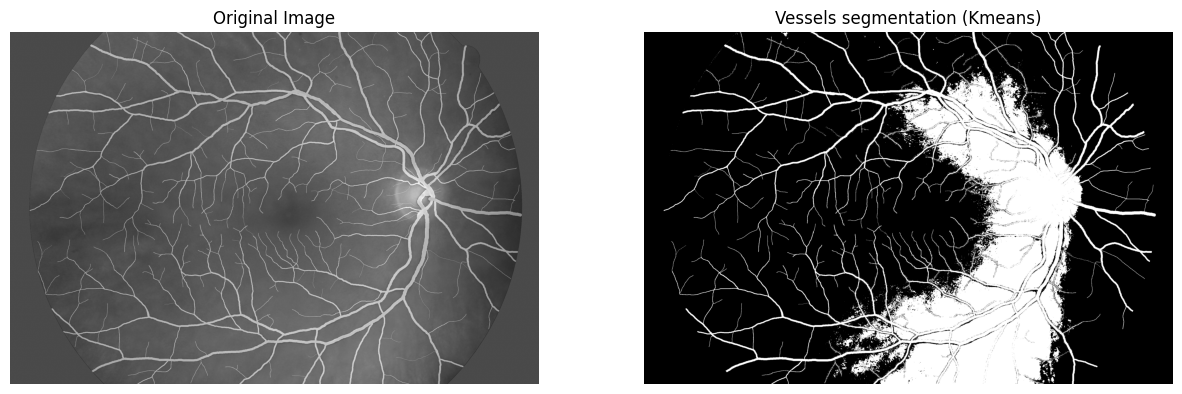

In [4]:
from sklearn.cluster import KMeans
import numpy as np

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8)

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I_train)

# Apply to predict test image:
v_I_test = I_test.reshape(I_test.shape[0]*I_test.shape[1],1).astype(np.uint8) # reshape image as 1d array

v_kmeans = kmeans.predict(v_I_test)
#v_kmeans= np.logical_not(v_kmeans) # use when the pattern is associated to cluster 0 (vessels shoyld be white)
I_kmeans = np.array(v_kmeans).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Vessels segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

In [5]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import mixture

#calcula el BIC per trobar el número de gaussianes òptim
NMAX = 2
bic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG,covariance_type='full').fit(v_I_train)
    bic.append(gmm.bic(v_I_train))
    print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

[np.float64(77185719.14287177)]
[np.float64(77185719.14287177), np.float64(72587281.5913204)]
...and the winner is GMM model G = 2


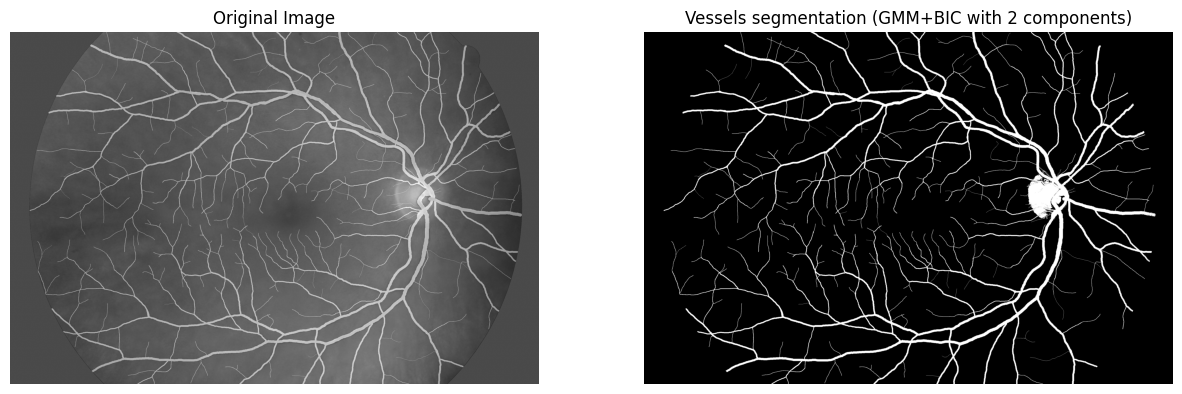

In [6]:
gmmw = mixture.GaussianMixture(n_components=idx_winner+1).fit(v_I_train) # fit again best GMM model
v_agg = gmmw.fit_predict(v_I_test)
I_gmm = np.array(v_agg).reshape(I_test.shape[0],I_test.shape[1])# Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_gmm,cmap='gray')
ax2.set_title('Vessels segmentation (GMM+BIC with {} components)'.format(idx_winner+1))
ax2.set_axis_off()
plt.show()